Part 1

In [53]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import plotly.graph_objs as go

In [15]:
def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * z ** 2 * (sigma_1 ** 2 + sigma_2 **2 / k) / (delta_effect ** 2)
    return n

In [37]:
def count_duration(power, effect):
    
    return duration(k=1, delta_effect=effect, sigma_1=1/2, sigma_2=np.sqrt(1/4 - effect**2), beta=1 - power)

In [38]:
def exp_destrib(duration, effect):
    p_values = []
    size = int(duration)
    n_exp = 10000
    for i in range(n_exp):
        x_a = sps.expon.rvs(scale=1/2, size=size)
        x_b = sps.expon.rvs(scale=1/2 + effect, size=size)
        p_value = sps.ttest_ind(x_a, x_b).pvalue
        p_values.append(p_value)
    p_values = np.array(p_values)
    return p_values[p_values < 0.05].shape[0] / p_values.shape[0]

In [40]:
print(f"effect: {0.03}, power: {0.8}, duration: {count_duration(0.8, 0.03)}, new_power: {exp_destrib(count_duration(0.8, 0.03)/2, 0.03)}")

effect: 0.03, power: 0.8, duration: 8705.2797231414, new_power: 0.7799


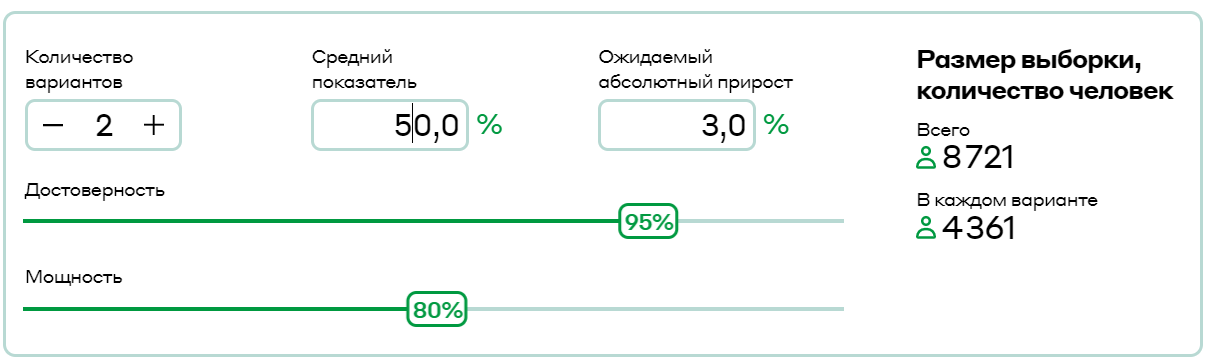

Part 2

In [65]:
def linearization(effect):
    n_exp = 1000
    p_values = []
    p_values_lin = []
    for _ in range(n_exp):
        records = []
        for i in range(100):
            n_views = int(sps.expon.rvs(loc=100, scale=100))
            clicks = sps.bernoulli.rvs(p=0.05, size=n_views)
            records.append([n_views, np.sum(clicks), np.sum(clicks)/ n_views, "A"])
        for i in range(100):
            n_views = int(sps.expon.rvs(loc=100, scale=100))
            clicks = sps.bernoulli.rvs(p=0.05 + effect, size=n_views)
            records.append([n_views, np.sum(clicks), np.sum(clicks)/ n_views, "B"])
        df_data = pd.DataFrame(records, columns=["views", "clicks", "cr", "group"])
        cr_A = df_data[df_data["group"] == "A"]["clicks"].sum() / df_data[df_data["group"] == "A"]["views"].sum()
        df_data["cr_lin"] = df_data["clicks"] - cr_A * df_data["views"]

        x_a = df_data[df_data["group"] == "A"]["cr"]
        x_b = df_data[df_data["group"] == "B"]["cr"]
        p_value = sps.ttest_ind(x_a, x_b).pvalue
        p_values.append(p_value)
    
        x_a_lin = df_data[df_data["group"] == "A"]["cr_lin"]
        x_b_lin = df_data[df_data["group"] == "B"]["cr_lin"]
        p_value_lin = sps.ttest_ind(x_a_lin, x_b_lin).pvalue
        p_values_lin.append(p_value_lin)
        
    return p_values, p_values_lin

In [75]:
def get_qq_plot(p_values):
    """Рисует распределение p-value"""
    p_values = np.array(p_values)
    probs = []
    x = [0.01 * i for i in range(101)]
    for i in range(101):
        alpha_step = 0.01 * i
        probs.append(p_values[p_values < alpha_step].shape[0] / p_values.shape[0])
    fig = go.Figure([go.Scatter(x=x, y=probs, mode="markers", name="p_value"),
                 go.Scatter(x=x, y=x, mode="lines", name="uniform")])
    fig.update_layout(height=600, width=600, title="Q-Q plot") 
    return fig

In [76]:
def get_power(p_values, alpha=0.05):
    """Оценка мощности критерия, при условии, что значения p_value взяты при наличии 
    различий в сравниваемых выборках 
    """
    p_values = np.array(p_values)
    return p_values[p_values < alpha].shape[0] / p_values.shape[0] * 100

In [77]:
p_values, p_values_lin = linearization(0.005)

In [78]:
get_qq_plot(p_values)

In [79]:
get_qq_plot(p_values_lin)

In [80]:
p_values = np.array(p_values)
p_values_lin = np.array(p_values_lin)

print("Power without Linearization:",
      get_power(p_values))

print("Power with Linearization:",
      get_power(p_values_lin))

Power without Linearization: 52.2
Power with Linearization: 60.8


Part 3

In [84]:
%%time
effect = 0.005
n_exp = 1000
p_values = []
p_values_cuped = []
size = 1000

# Pre_experiment
pre_exp = sps.norm.rvs(loc=100, scale=20, size=size)
for _ in range(n_exp):
    
    
    
    df_A = pd.DataFrame()
    df_A["user"] = [f"A_{x:5}" for x in range(size)]
    df_A["pre_exp"] = pre_exp
    df_A["payments"] =  sps.norm.rvs(loc=1, scale=100, size=size) * df_A["pre_exp"]
    
    df_B = pd.DataFrame()
    df_B["pre_exp"] = pre_exp
    df_B["user"] = [f"B_{x:5}" for x in range(size)]
    df_B["payments"] = sps.norm.rvs(loc=1 + effect, scale=100, size=size) * df_B["pre_exp"]
    
    p_values.append(sps.ttest_ind(df_A["payments"], df_B["payments"]).pvalue)
    
    x_a = df_A["pre_exp"]
    x_b = df_B["pre_exp"]
    y_a = df_A["payments"]
    y_b = df_B["payments"]
    theta = np.cov(x_a, y_a)[0,1] / np.std(x_a)**2
    
    df_A["payments_cuped"] = df_A["payments"] - theta * df_A["pre_exp"]
    df_B["payments_cuped"] = df_B["payments"] - theta * df_B["pre_exp"]
    
    p_values_cuped.append(sps.ttest_ind(df_A["payments_cuped"], df_B["payments_cuped"]).pvalue)

Wall time: 13.7 s


In [85]:
get_qq_plot(p_values_cuped)

In [86]:
p_values = np.array(p_values)
p_values_lin = np.array(p_values_lin)

print("Power without CUPED:",
      get_power(p_values))

print("Power with CUPED:",
      get_power(p_values_lin))

Power without CUPED: 5.0
Power with CUPED: 60.8
